# Table of Contents
 <p><div class="lev1"><a href="#Initialize-Environment"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev1"><a href="#Subgraph-of-Brain-Systems"><span class="toc-item-num">2&nbsp;&nbsp;</span>Subgraph of Brain Systems</a></div><div class="lev2"><a href="#Focal-vs-Distributed-Subgraphs"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Focal vs Distributed Subgraphs</a></div><div class="lev2"><a href="#Formulate-ROI-Dict"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Formulate ROI Dict</a></div><div class="lev2"><a href="#Convert-ROI-Subgraphs-to-Brain-System-Subgraphs"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert ROI Subgraphs to Brain System Subgraphs</a></div><div class="lev2"><a href="#Subgraph-Expression-Contrasts"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Subgraph Expression Contrasts</a></div>

# Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis Notebooks/')

path_CoreData = '/home/akhambhati/JagHome/hoth_research/CoreData/Sync_Cog_Control-Medaglia'
path_PeriphData = '/home/akhambhati/JagHome/hoth_research/PeriphData/ds-NMF_CogControl'
path_InpData = path_PeriphData + '/e02-FuncSubg'
path_ExpData = path_PeriphData + '/e04-FuncSubg_Dynamics'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Subgraph of Brain Systems

In [66]:
df_nmf = np.load('{}/NMF_Consensus.npz'.format(path_InpData), mmap_mode='r')
fac_subnet = df_nmf['fac_subnet']
fac_coef = df_nmf['fac_coef']
n_fac = fac_subnet.shape[0]
n_conn = fac_subnet.shape[1]
n_obs = fac_coef.shape[1]

## Focal vs Distributed Subgraphs

(0, 54)

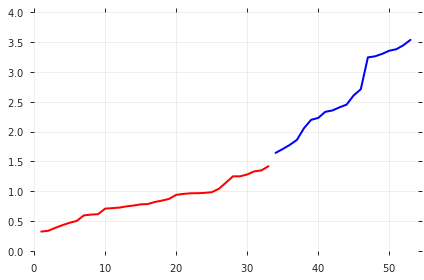

In [67]:
real_subg_skew = np.array([stats.skew(subg) for subg in fac_subnet])
real_ix = np.argsort(real_subg_skew)

n_null = 10000
rnd_coef = np.random.uniform(size=(n_null, n_fac))
rnd_subnet = np.dot(rnd_coef, fac_subnet)

rnd_subg_skew = np.array([stats.skew(subg) for subg in rnd_subnet])
rnd_ix = np.argsort(rnd_subg_skew)

low_ix = np.flatnonzero(real_subg_skew[real_ix] < np.min(rnd_subg_skew))
mid_ix = np.flatnonzero((real_subg_skew[real_ix] >= np.min(rnd_subg_skew)) &
                        (real_subg_skew[real_ix] <= np.max(rnd_subg_skew)))
high_ix = np.flatnonzero(real_subg_skew[real_ix] > np.max(rnd_subg_skew))

%matplotlib inline
plt.figure()
ax = plt.subplot(111)
ax.plot(low_ix, real_subg_skew[real_ix][low_ix], color='b')
ax.plot(mid_ix, real_subg_skew[real_ix][mid_ix], color='r')
ax.plot(high_ix, real_subg_skew[real_ix][high_ix], color='b')
ax.set_xlim([0, n_fac])

## Formulate ROI Dict

In [68]:
df_parcel = pd.read_csv('{}/LausanneScale125.csv'.format(path_CoreData))

all_roi_names = []

roi_dict = {}
for lbl_id, lbl_roi, lbl_hemi in zip(df_parcel.Label_ID, df_parcel.ROI, df_parcel.Hemisphere):
    roi_name = '{}_{}'.format(lbl_hemi, lbl_roi.split('_')[0])
    #roi_name = lbl_roi.split('_')[0]
    
    if roi_name not in all_roi_names:
        all_roi_names.append(roi_name)

    try:
        roi_dict[roi_name]
    except KeyError:
        roi_dict[roi_name] = []

    roi_dict[roi_name].append(lbl_id-1)
n_roi = len(all_roi_names)
n_conn_roi = int(n_roi*(n_roi-1)*0.5)

## Convert ROI Subgraphs to Brain System Subgraphs

In [69]:
bs_fac_subnet = np.zeros((n_fac, n_conn_roi))
for fac_i, subg in enumerate(fac_subnet):
    adj = conv_cfg_vec_to_adj_matr(subg)
    
    tmp_subnet = np.zeros((1, n_roi, n_roi))
    for ij_ii, ij_roi in enumerate(all_roi_names):
        for ik_ii, ik_roi in enumerate(all_roi_names):
            
            mean_conn = adj[roi_dict[ij_roi], :][:, roi_dict[ik_roi]].mean()
            tmp_subnet[0, ij_ii, ik_ii] = mean_conn
    bs_fac_subnet[fac_i, :] = conv_adj_matr_to_cfg_matr(tmp_subnet)[0, :]

## Subgraph Expression Contrasts

LH_postcentral
LH_precentral
LH_parsopercularis
LH_thalamusproper
LH_bankssts
RH_postcentral



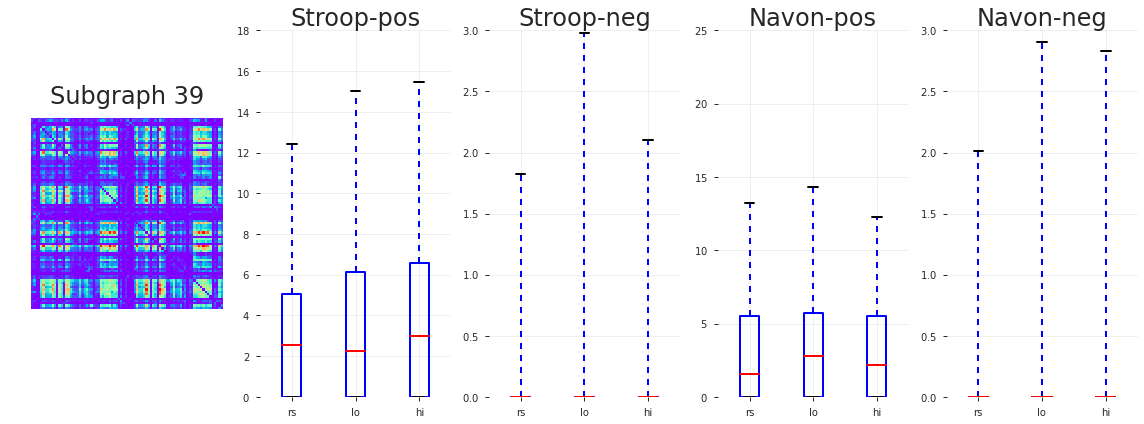

RH_parsopercularis
RH_bankssts
RH_parsorbitalis
LH_parstriangularis
LH_paracentral
LH_putamen



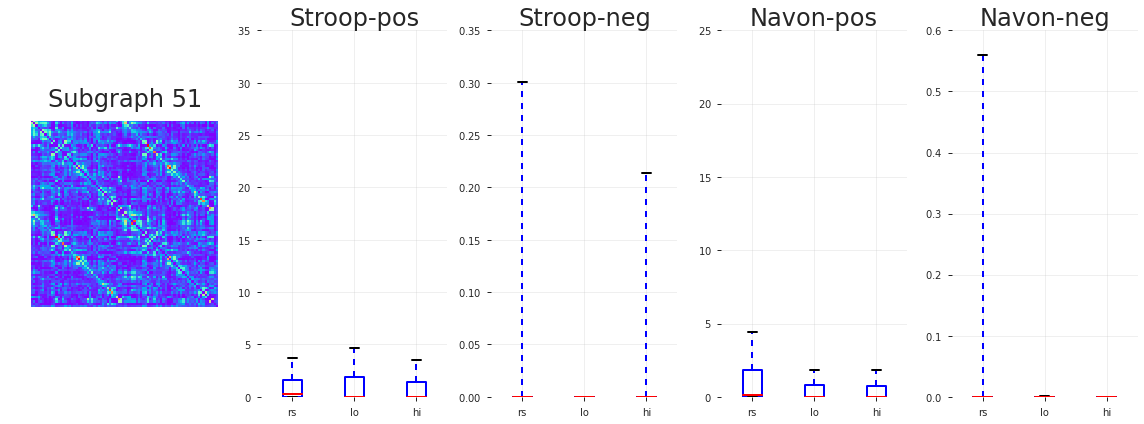

RH_transversetemporal
LH_transversetemporal
RH_postcentral
RH_insula
LH_cuneus
RH_precentral



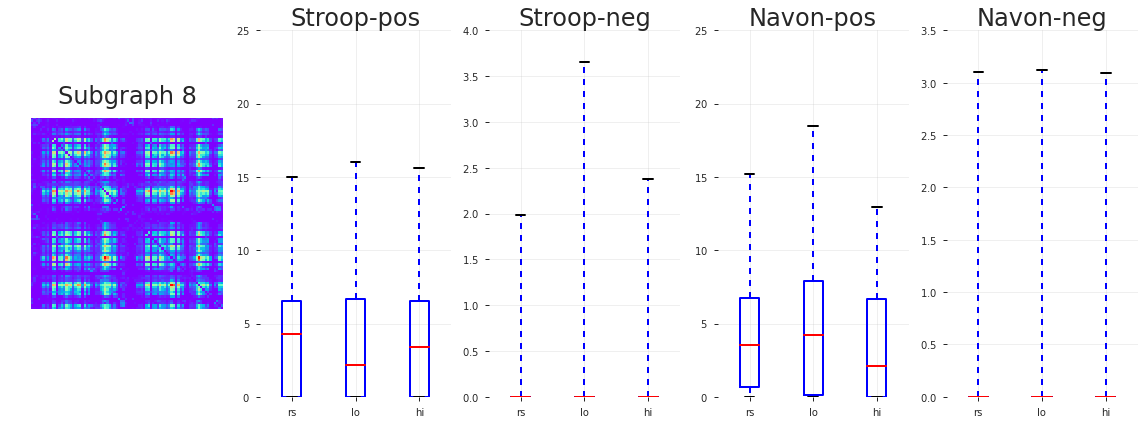

RH_postcentral
LH_medialorbitofrontal
LH_paracentral
LH_rostralanteriorcingulate
LH_postcentral
RH_paracentral



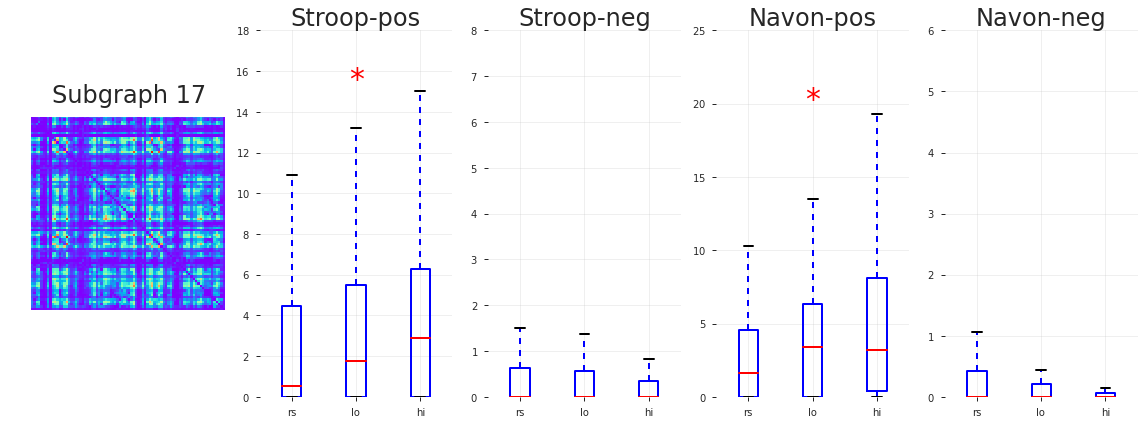

RH_rostralmiddlefrontal
RH_parsorbitalis
RH_caudalmiddlefrontal
RH_middletemporal
RH_inferiorparietal
RH_parsopercularis



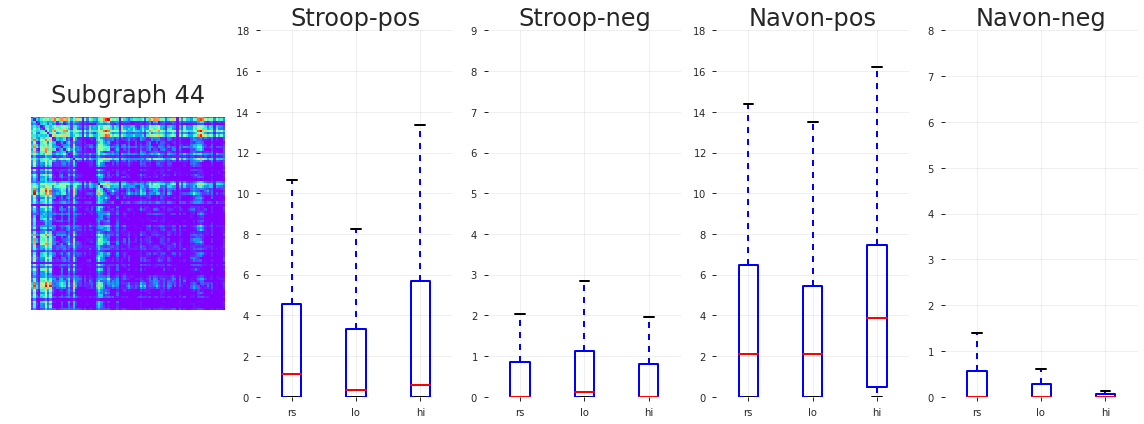

LH_parsorbitalis
RH_parsorbitalis
LH_parstriangularis
LH_middletemporal
LH_rostralanteriorcingulate
RH_middletemporal



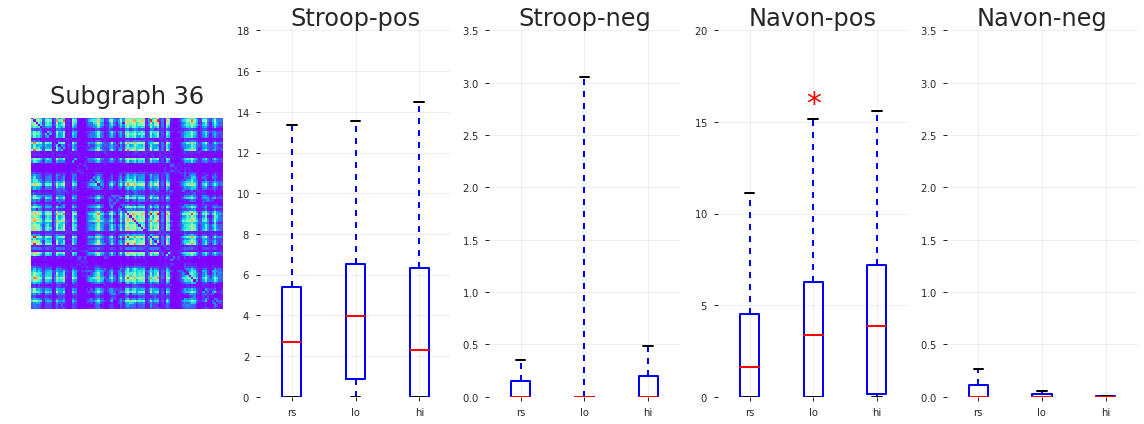

LH_lateraloccipital
LH_fusiform
RH_lateraloccipital
RH_fusiform
LH_precentral
LH_superiorparietal



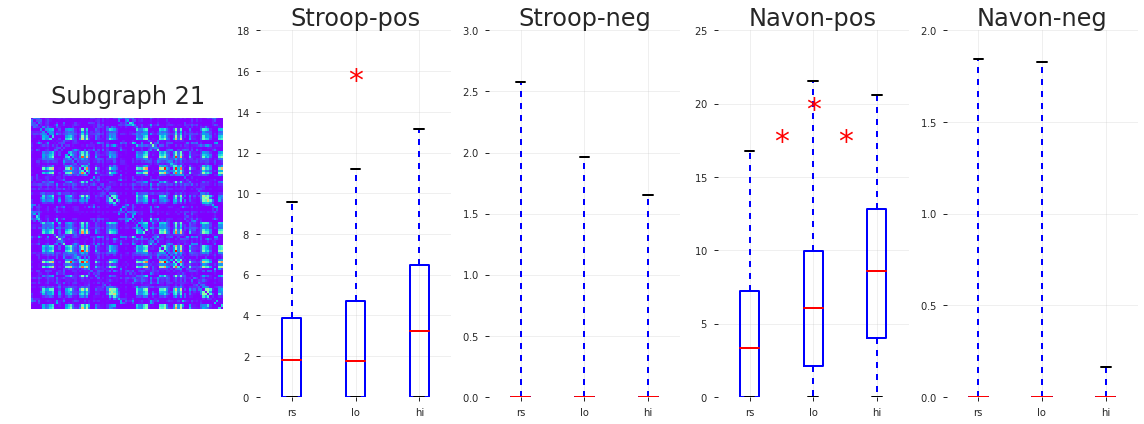

RH_parstriangularis
RH_parsopercularis
LH_parsopercularis
RH_insula
LH_insula
RH_caudalanteriorcingulate



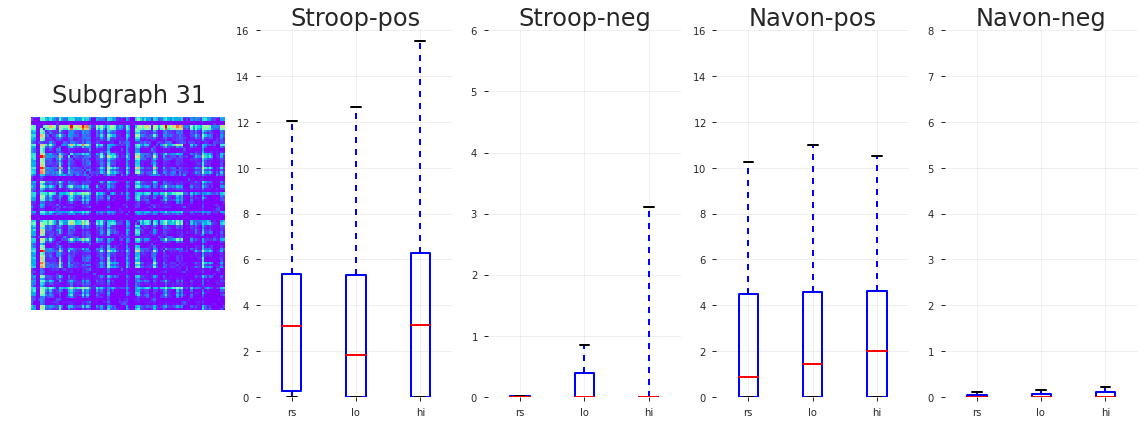

LH_parstriangularis
LH_parsorbitalis
LH_bankssts
LH_middletemporal
LH_caudalmiddlefrontal
LH_inferiorparietal



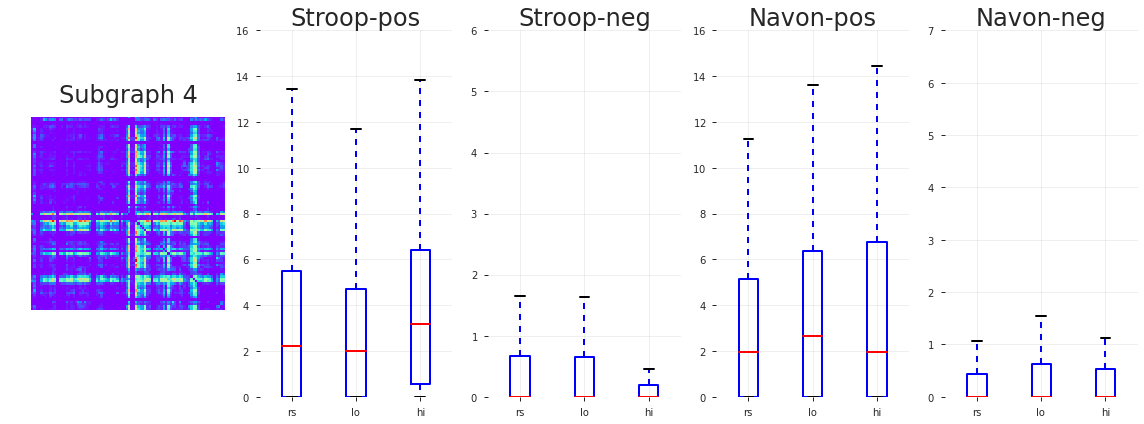

RH_caudalmiddlefrontal
RH_inferiorparietal
RH_rostralmiddlefrontal
RH_parsorbitalis
LH_lateraloccipital
RH_middletemporal



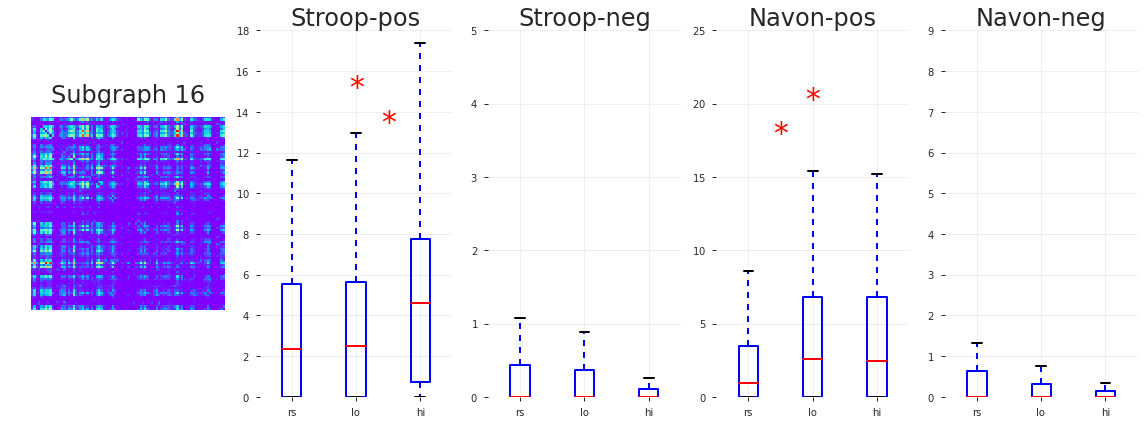

LH_paracentral
RH_paracentral
RH_posteriorcingulate
LH_posteriorcingulate
LH_caudalanteriorcingulate
LH_precentral



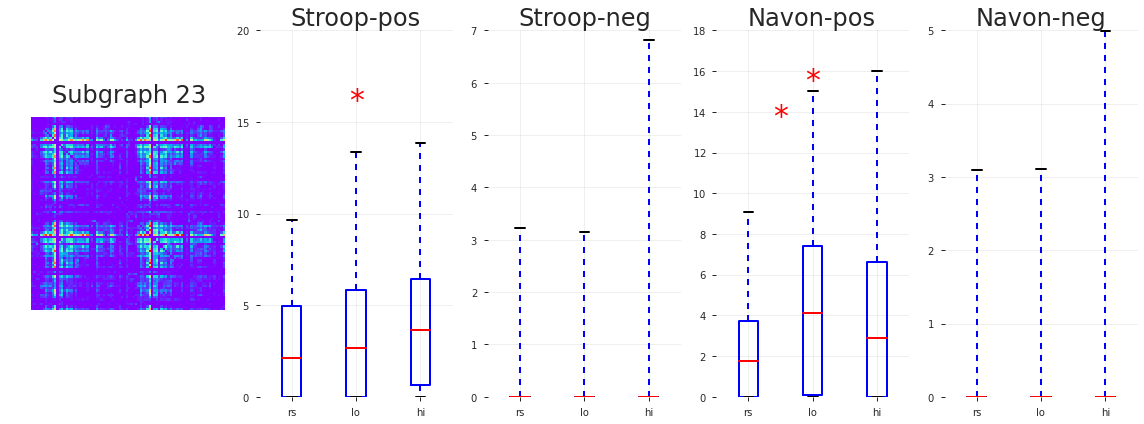

LH_cuneus
LH_pericalcarine
RH_pericalcarine
RH_cuneus
LH_lingual
RH_lingual



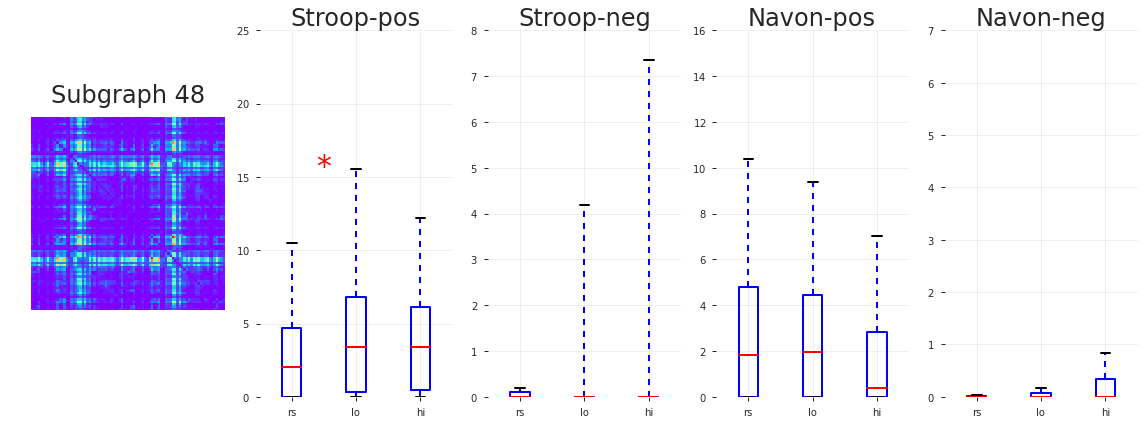

RH_entorhinal
LH_entorhinal
RH_temporalpole
LH_temporalpole
RH_amygdala
RH_inferiortemporal



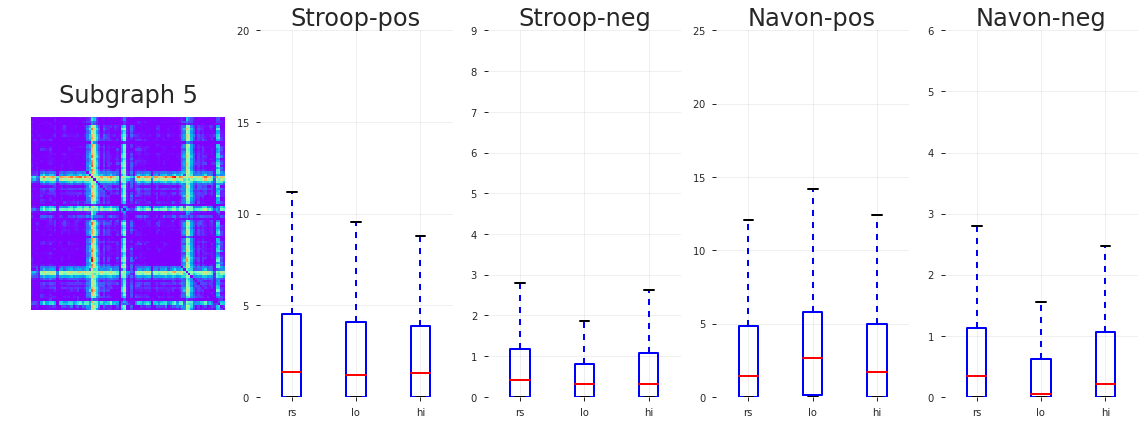

LH_isthmuscingulate
RH_isthmuscingulate
LH_precuneus
RH_precuneus
LH_parahippocampal
RH_parahippocampal



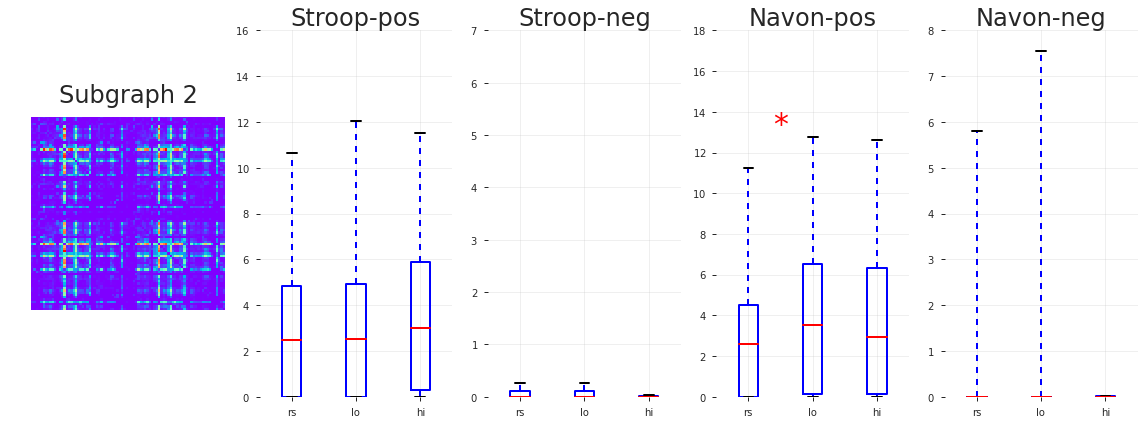

LH_pallidum
RH_pallidum
LH_accumbensarea
RH_accumbensarea
RH_putamen
LH_putamen



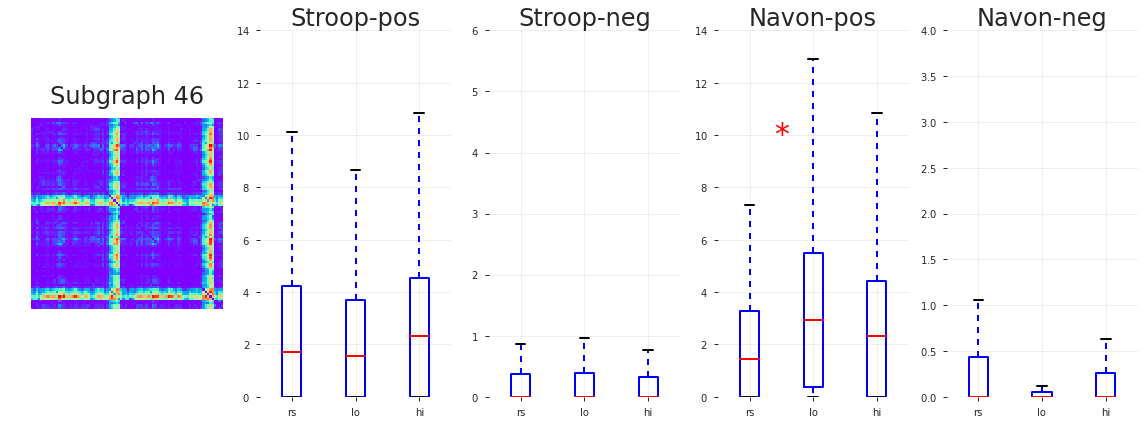

RH_accumbensarea
LH_accumbensarea
RH_medialorbitofrontal
LH_medialorbitofrontal
RH_amygdala
LH_amygdala



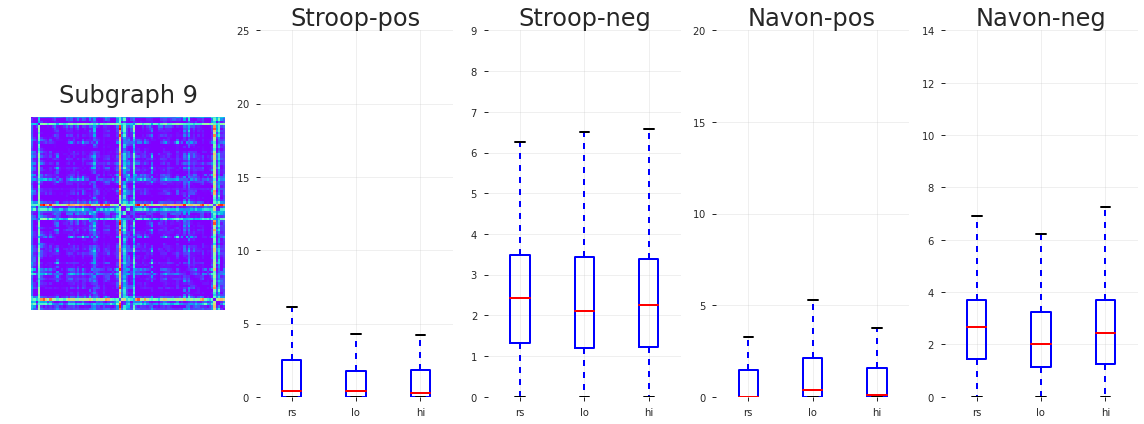

LH_lateraloccipital
RH_lateraloccipital
RH_transversetemporal
LH_superiorparietal
LH_fusiform
LH_transversetemporal



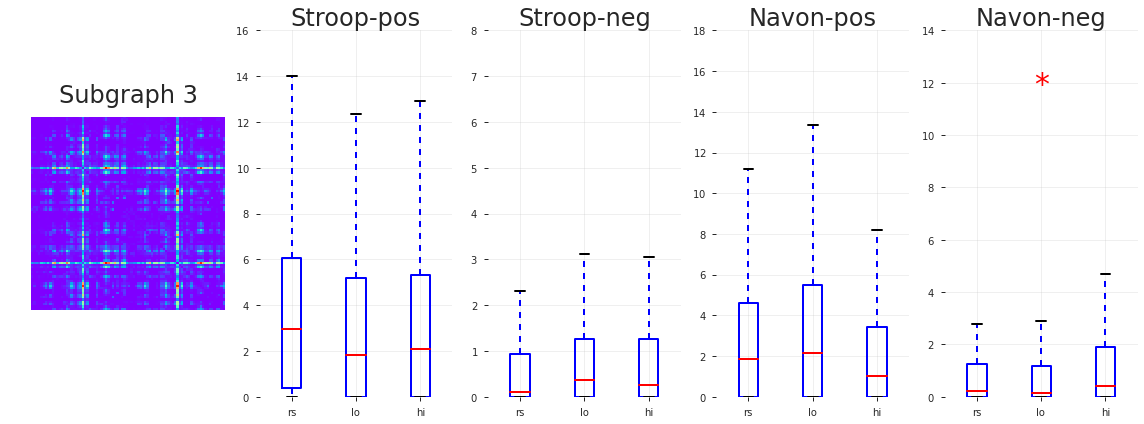

LH_rostralanteriorcingulate
RH_rostralanteriorcingulate
LH_frontalpole
LH_medialorbitofrontal
LH_lateraloccipital
RH_lateraloccipital



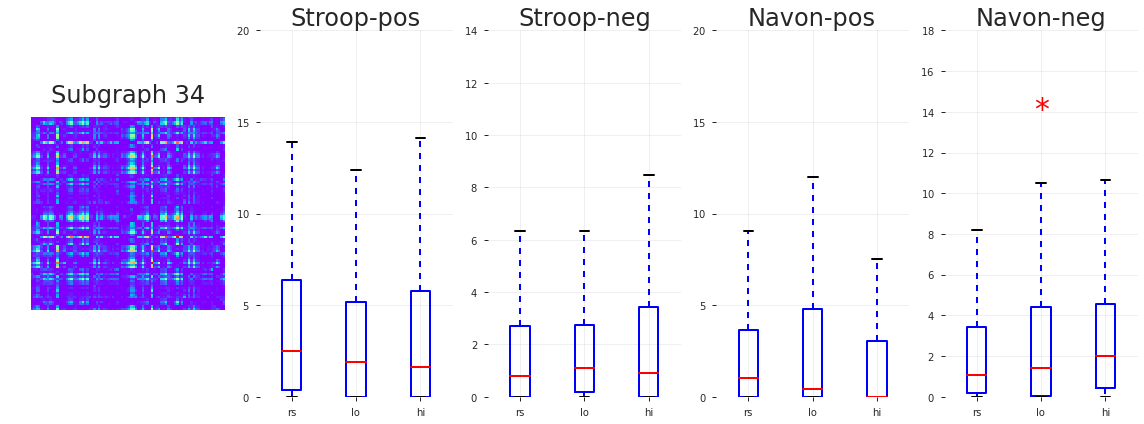

LH_cuneus
LH_pericalcarine
RH_cuneus
LH_lingual
RH_pericalcarine
RH_lingual



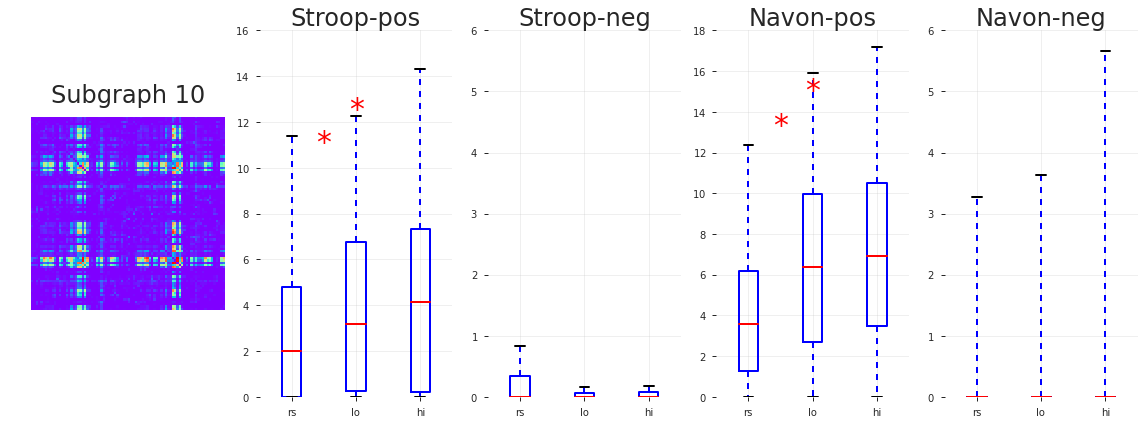

RH_frontalpole
RH_lateralorbitofrontal
LH_lateralorbitofrontal
RH_parsorbitalis
LH_frontalpole
LH_parsorbitalis



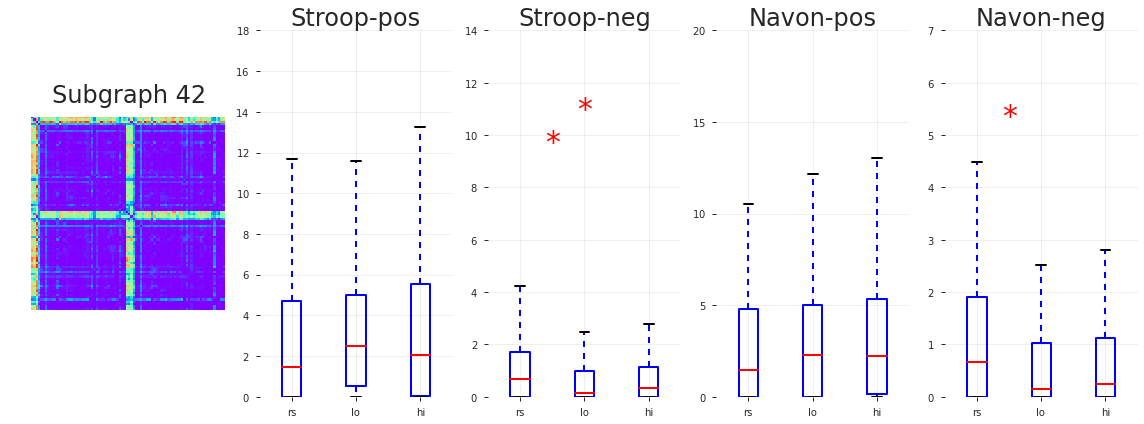

In [122]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_lbl = np.unique(cfg_key)
key_grp = [['adj_rs_pos_Stroop', 'adj_lo_pos_Stroop', 'adj_hi_pos_Stroop'],
           ['adj_rs_neg_Stroop', 'adj_lo_neg_Stroop', 'adj_hi_neg_Stroop'],
           ['adj_rs_pos_Navon', 'adj_lo_pos_Navon', 'adj_hi_pos_Navon'],
           ['adj_rs_neg_Navon', 'adj_lo_neg_Navon', 'adj_hi_neg_Navon']]


#sel_fac_ix = xrange(n_fac)
sel_fac_ix = real_ix[high_ix]
alpha = 0.05
n_comp = len(high_ix*3*4)
adj_alpha = alpha / n_comp

# Plot each result
for fac_ii in sel_fac_ix:
    plt.figure(figsize=(16,6))
    ax = plt.subplot(1, 1+len(key_grp), 1)
    ax.matshow(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), cmap='rainbow')
    ax.set_axis_off()

    ax.set_title('Subgraph {}'.format(fac_ii+1))
    sort_roi = np.argsort(np.sum(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), axis=0))[::-1]
    print('{}\n{}\n{}\n{}\n{}\n{}\n'.format(all_roi_names[sort_roi[0]],
                                            all_roi_names[sort_roi[1]],
                                            all_roi_names[sort_roi[2]],
                                            all_roi_names[sort_roi[3]],
                                            all_roi_names[sort_roi[4]],
                                            all_roi_names[sort_roi[5]]))

    for grp_ii, grp in enumerate(key_grp):
        dists = []

        for key in grp:
            key_ix = np.flatnonzero(cfg_key == key)

            #mean_subj_coef = np.mean(fac_coef[fac_ii, key_ix].reshape(-1, 6), axis=1)
            #dists.append(mean_subj_coef)
            all_coef = fac_coef[fac_ii, key_ix]
            dists.append(all_coef)

        ax = plt.subplot(1, 1+len(key_grp), grp_ii+2)
        ax.boxplot(dists)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticklabels([gg.split('_')[1] for gg in grp])

        ax.set_title('{}-{}'.format(grp[0].split('_')[-1],
                                    grp[0].split('_')[-2]))
        
        rs_lo_ts, rs_lo_pv = stats.ttest_rel(dists[0], dists[1])
        rs_hi_ts, rs_hi_pv = stats.ttest_rel(dists[0], dists[2])
        lo_hi_ts, lo_hi_pv = stats.ttest_rel(dists[1], dists[2])            
     
        
        if rs_lo_pv < adj_alpha:
            ax.text(1.4, np.max(dists)*0.75, '*', fontsize=30, color='r')
        if lo_hi_pv < adj_alpha:
            ax.text(2.4, np.max(dists)*0.75, '*', fontsize=30, color='r')
        if rs_hi_pv < adj_alpha:
            ax.text(1.9, np.max(dists)*0.85, '*', fontsize=30, color='r')
    plt.show()